In [19]:
!pip install opencv-python -U

### Главная задача - поиск мусорных баков на фото и определение их заполнености 

Для решения этой задачи мы выбрали нейросеть Yolo(v4) - она довольно быстрая и точная. Блокнот с обучением (настроенная копия блокнота [AI Guy](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqazZ4WG5vZkR3MDlCdHJMd3U5QXF0YmpsWHRXd3xBQ3Jtc0tsMzhwNFVHdlFZZ04wMkhSTUhLQk9Dd1JVU2hpUEFPYlctZkNrMmJYdXRSTy0yMS00ZlBDNXI3TFJ2eWpmUUtFME91OHlxTVZ1ZVo1cGhZSmJmZHlBcW8tcC1ELUlxdUxtNENWbEpFM3RFaFBoM1E3UQ&q=https%3A%2F%2Fcolab.research.google.com%2Fdrive%2F1_GdoqCJWXsChrOiY8sZMr_zbr_fH-0Fg%3Fusp%3Dsharing)) находится рядом c этим блокнотом. 

В рамках хакатона мы использовали датасет, предоставленный кейсодержателями, дополнительно дособрав информацию с гугл-карт и интернета, добавили дополнительный класс с мусорками - для демонстрации одной из креативных идей. Весь датасет (размеченный также в формате YOLO) находится [вот тут](https://https://drive.google.com/drive/folders/1TRc53T7j8Hej-TmKnNNze_UauBTvHmzD?usp=sharing)



In [3]:
from google.colab.patches import cv2_imshow
import cv2
import os
import numpy as np

### 1. Подключаем все нейронки, которые используем в работе

1) Обученная нами нейросетка на трех классах (пустые и полные баки, мусорные корзины)

In [5]:
yolo_folder = '/content/drive/MyDrive/hackaton-trash/'
yolo_trashcans_weights = yolo_folder + 'backup/yolov4-trashcans_last.weights'
yolo_trashcans_cfg     = yolo_folder + 'darknet/cfg/yolov4-trashcans.cfg'
yolo_trashcans_classes = yolo_folder + 'names.txt'

net_trashcans = cv2.dnn_DetectionModel(yolo_trashcans_cfg, yolo_trashcans_weights)
net_trashcans.setInputSize(640, 640)
net_trashcans.setInputScale(1.0 / 255)
net_trashcans.setInputSwapRB(True)

with open (yolo_trashcans_classes) as f:
    labels_trashcans = f.read().strip().split('\n')

2) Обученная [AlexeyAB](https://github.com/AlexeyAB/darknet) нейросеть на MS COCO. Используется для определения бездомных животных, людей и машин.

!TODO: + дособрать и разметить данные с камер + переобучить одну общую сетку на нужной нам части датасета и собранных данных

In [20]:
yolo_folder = '/content/drive/MyDrive/hackaton-trash/yolo-coco/'
yolo_coco_weights = yolo_folder + 'yolov4-coco.weights'
yolo_coco_cfg     = yolo_folder + 'yolo-coco.cfg'
yolo_coco_classes = yolo_folder + 'coco_names.txt'

#net = cv2.dnn.readNet(yolo_weights, yolo_cfg)
net_coco = cv2.dnn_DetectionModel(yolo_coco_cfg, yolo_coco_weights)
net_coco.setInputSize(640, 640)
net_coco.setInputScale(1.0 / 255)
net_coco.setInputSwapRB(True)

with open (yolo_coco_classes) as f:
    labels_coco = f.read().strip().split('\n')

### 2) Определение мусорных баков и детекция их наполненности

In [21]:
def draw_objects(frame, classes, confidences, boxes, labels):
  if (len(classes) == 0):
    return frame
  for classId, confidence, box in zip(classes.flatten(), confidences.flatten(), boxes):
    label = '%.2f' % confidence
    label = '%s: %s' % (labels[classId], label)
    color = (31, 182, 237)
    if (labels[classId] == 'garbage_can_empty'):
      color = (0, 255, 0)
    if (labels[classId] == 'garbage_can_full'):
      color = (0, 0, 255)
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    left, top, width, height = box
    top = max (top, labelSize[1])
    cv2.rectangle(frame, box, color, thickness=2)
    cv2.rectangle(frame, (left, top-labelSize[1]), (left+labelSize[0], top+baseLine), color, cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0))
  return frame

In [22]:
def draw_garbage_bins(frame):
  classes, confidences, boxes = net_trashcans.detect(frame, confThreshold=0.7, nmsThreshold=0.3) #Ставим уверенность побольше и порог nms поменьше
  draw_frame = draw_objects(frame, classes, confidences, boxes, labels_trashcans)
  return draw_frame

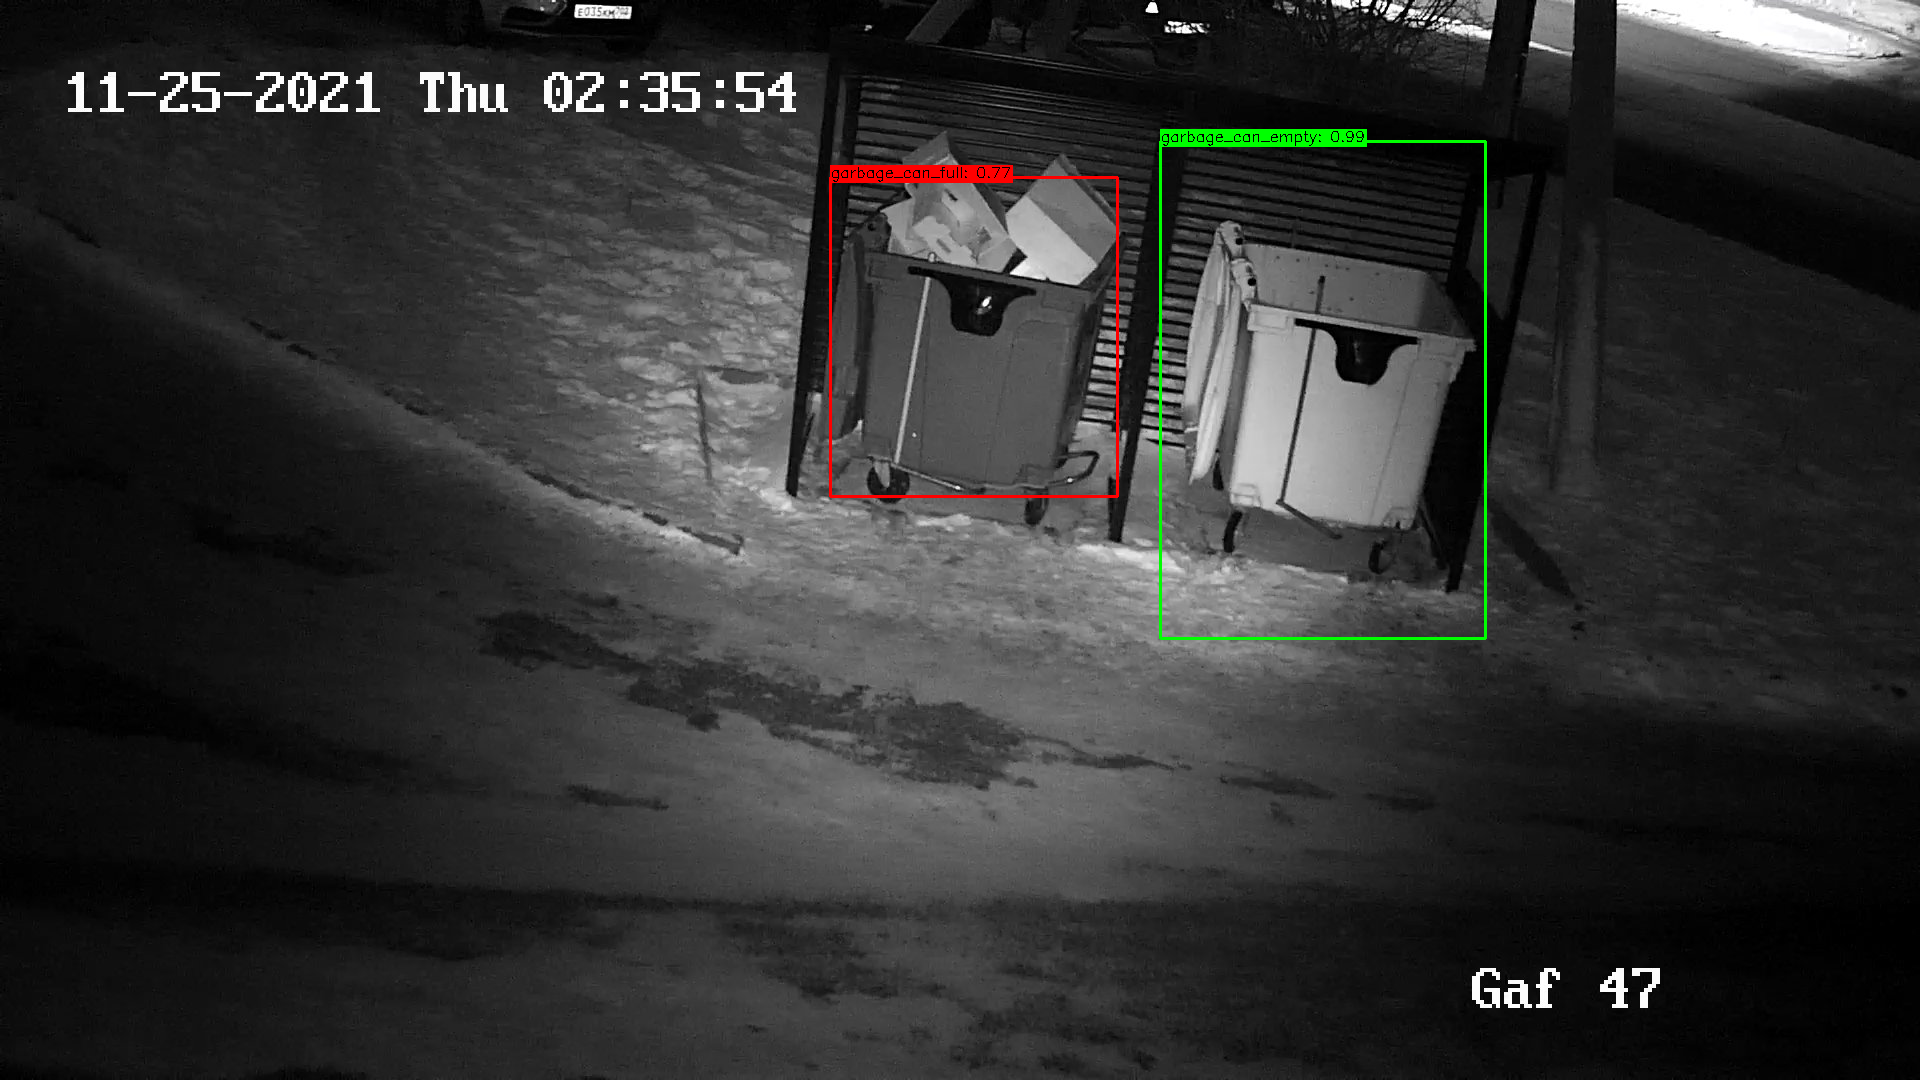

In [23]:
frame = cv2.imread('/content/drive/MyDrive/hackaton-trash/JP-notebooks/test2.jpg')
draw_frame = draw_garbage_bins(frame)
cv2_imshow(draw_frame)

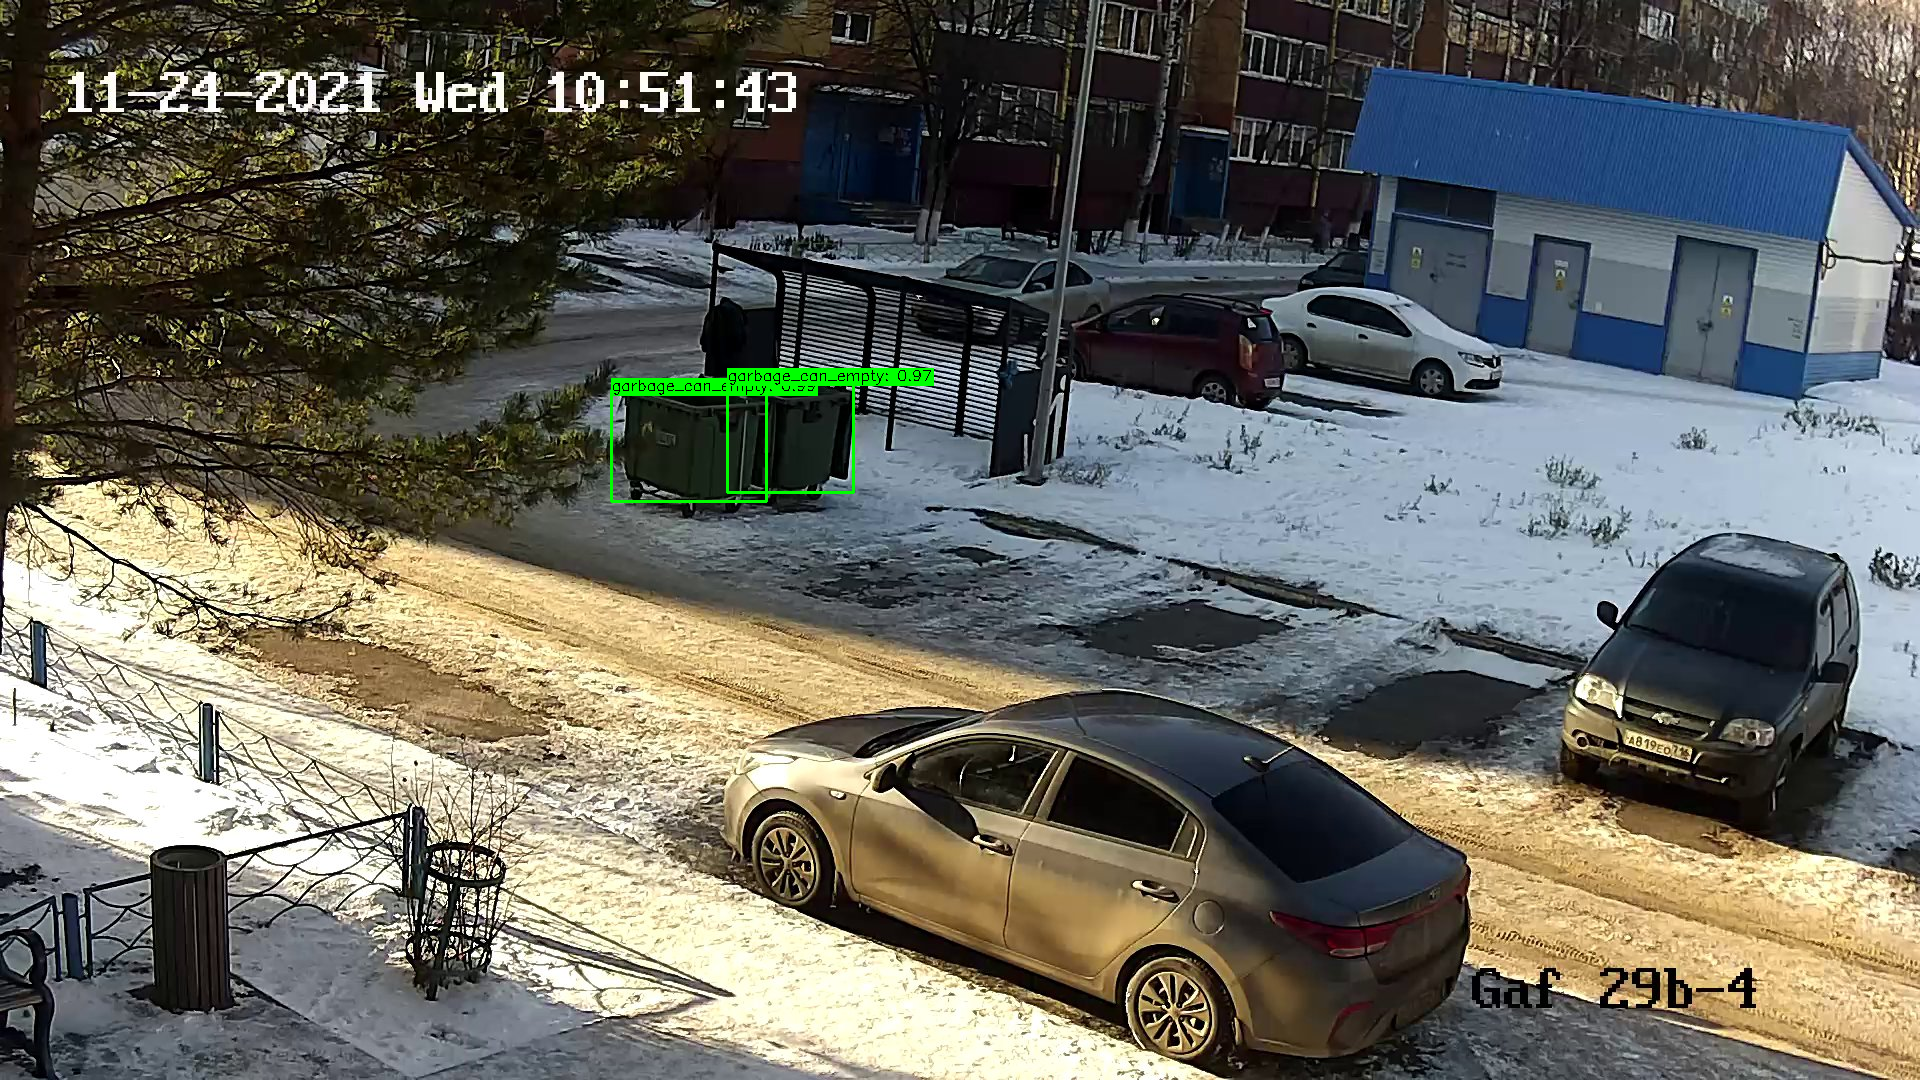

In [26]:
frame = cv2.imread('/content/drive/MyDrive/hackaton-trash/JP-notebooks/test4.jpg')
draw_frame = draw_garbage_bins(frame)
cv2_imshow(draw_frame)

### 2) Определение бездомных собак, сбивающихся в стаи

In [41]:
def draw_dogs(frame):
  classes, confidences, boxes = net_coco.detect(frame, confThreshold=0.1, nmsThreshold=0.5) #Ставим уверенность поменьше (собаки - объект маленький) и порог nms побольше (чтобы не определить слишком много собак)
  if (len(classes) == 0):
    return frame
  for classId, confidence, box in zip(classes.flatten(), confidences.flatten(), boxes):
    if(labels_coco[classId] != 'dog'): # Для картинки отобразим только собак
      continue
    label = '%.2f' % confidence
    label = '%s: %s' % (labels_coco[classId], label)
    color = (31, 182, 237)
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    left, top, width, height = box
    top = max (top, labelSize[1])
    cv2.rectangle(frame, box, color, thickness=2)
    cv2.rectangle(frame, (left, top-labelSize[1]), (left+labelSize[0], top+baseLine), color, cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0))
  return frame

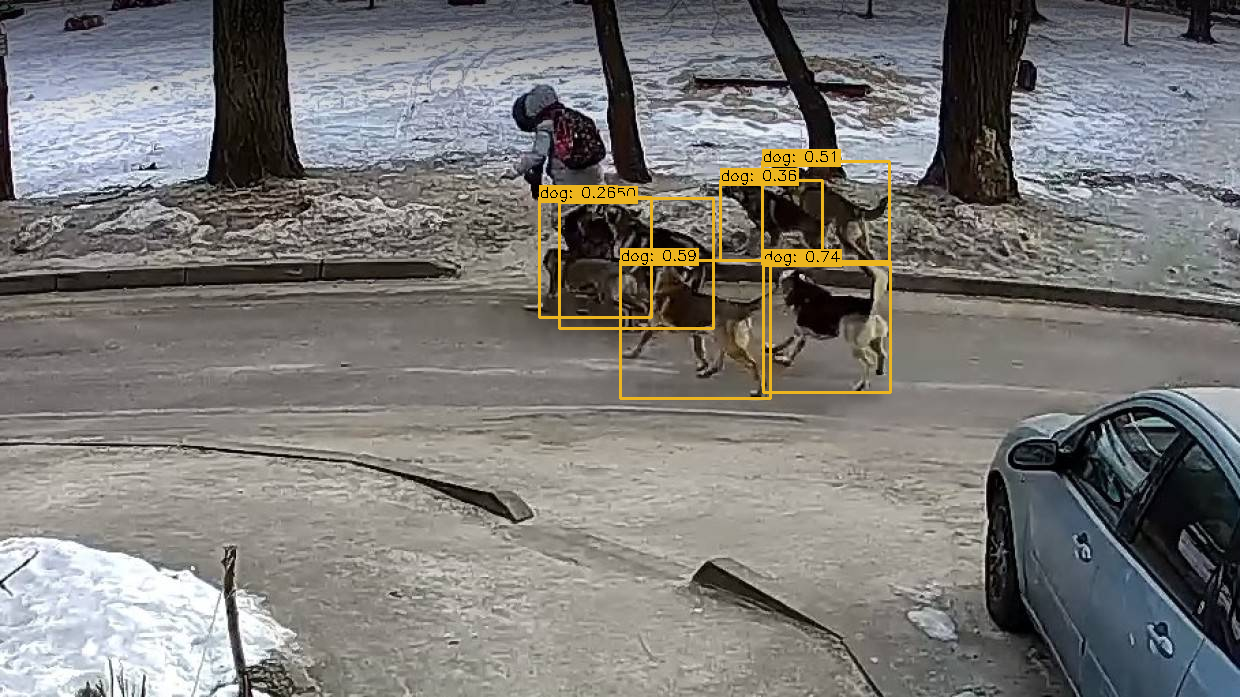

15


In [44]:
frame = cv2.imread('/content/drive/MyDrive/hackaton-trash/JP-notebooks/test7.jpeg')
draw_frame = draw_dogs(frame)
cv2_imshow(draw_frame)

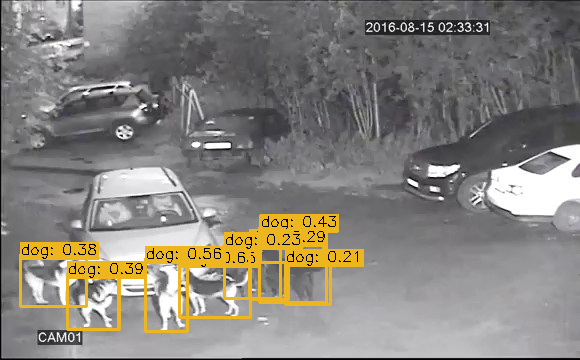

In [43]:
frame = cv2.imread('/content/drive/MyDrive/hackaton-trash/JP-notebooks/test9.jpg')
draw_frame = draw_dogs(frame)
cv2_imshow(draw_frame)